In [1]:
## IMPORTS ##
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
import cv2
from tensorflow import keras as k
from PIL import Image
from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils.class_weight import compute_class_weight


## Setting device to be GPU if available
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Check if GPU is available
device_name = tf.config.list_physical_devices('GPU')
if device_name:
    print(f"Using device: GPU - {device_name[0].name}")
else:
    print("Using device: CPU")

2025-01-09 08:12:36.239955: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-09 08:12:36.247035: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-09 08:12:36.255461: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-09 08:12:36.258004: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 08:12:36.264112: I tensorflow/core/platform/cpu_feature_guar

Using device: GPU - /physical_device:GPU:0


I0000 00:00:1736410357.374653   16815 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736410357.393565   16815 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736410357.393716   16815 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


## Exploring Dataset

In [2]:
dataset_path = "/home/lunet/coaoo/Downloads/Machine Learning/lung_dataset"
classes = os.listdir(dataset_path)

class_to_label = {class_name: idx for idx, class_name in enumerate(classes)}

# Initialize lists for paths and labels
paths = []
labels = []

# Collect paths and labels
for class_name in classes:
    class_folder = os.path.join(dataset_path, class_name)
    for file_name in os.listdir(class_folder):
        if file_name.endswith(('.png', '.jpg', '.jpeg')):  # Check for valid image extensions
            image_path = os.path.join(class_folder, file_name)
            paths.append(image_path)
            labels.append(class_to_label[class_name])

print(f"Total number of images: {len(paths)}")
print(f"Classes: {class_to_label}")

Total number of images: 15153
Classes: {'PNEUMONIA': 0, 'HEALTHY': 1, 'COVID': 2}


In [3]:
for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    print(f"{cls}: {len(os.listdir(class_path))} images")

PNEUMONIA: 1345 images
HEALTHY: 10192 images
COVID: 3616 images


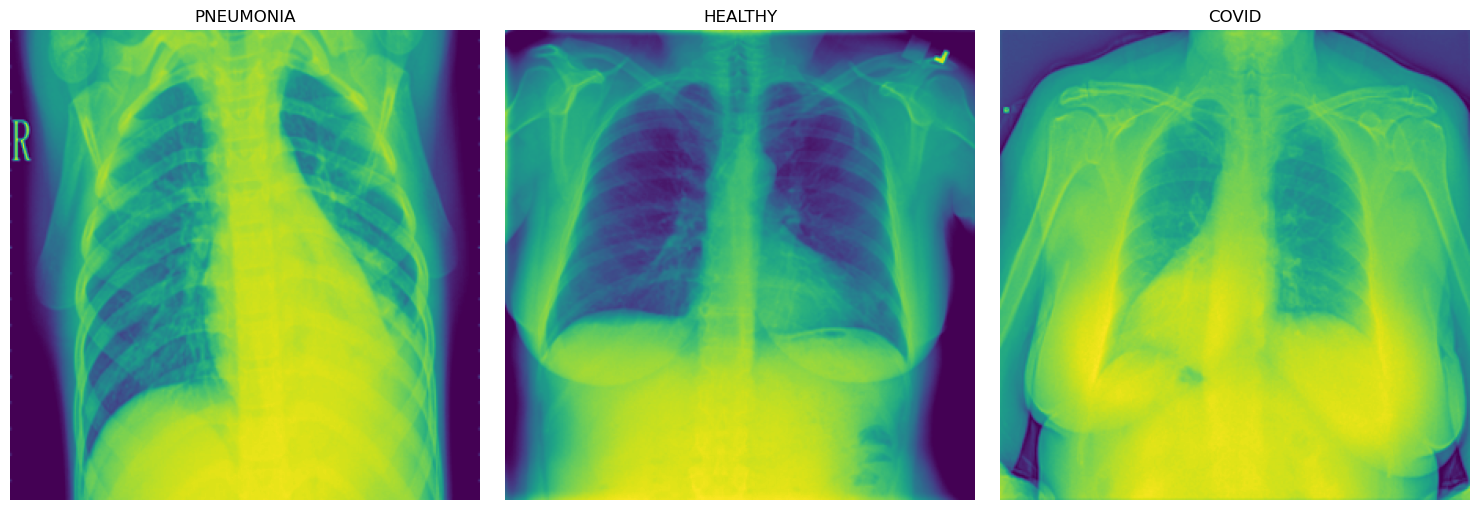

In [4]:
fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))
for i, cls in enumerate(classes):
    img_path = os.path.join(dataset_path, cls, os.listdir(os.path.join(dataset_path, cls))[0])
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(cls)
    axes[i].axis("off")
plt.tight_layout()
plt.show()

In [43]:
image_sizes = []
for path in paths:
    img = cv2.imread(path)
    if img is not None:
        image_sizes.append(img.shape[:2])  # (height, width)

image_sizes = np.array(image_sizes)
print("\nImage size analysis:")
print(f"Average dimensions: {image_sizes.mean(axis=0)}")
print(f"Min dimensions: {image_sizes.min(axis=0)}")
print(f"Max dimensions: {image_sizes.max(axis=0)}")



Image size analysis:
Average dimensions: [299. 299.]
Min dimensions: [299 299]
Max dimensions: [299 299]


## Pre Processing

In [6]:
def show_class_distribution_full(labels, class_names=None):
    """
    Displays the class distribution for the full dataset.

    Args:
        labels (array-like): Class labels for the full dataset.
        class_names (list or None): Optional class names to label the x-axis.
    """
    # Count class occurrences
    class_counts = Counter(labels)

    # Get all class labels (sorted for consistency)
    classes = sorted(class_counts.keys())
    values = [class_counts[cls] for cls in classes]

    # Create a bar plot
    x = np.arange(len(classes))  # Class positions

    plt.figure(figsize=(10, 6))
    plt.bar(x, values, color="skyblue")

    # Add labels, title, and legend
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.title("Class Distribution in Dataset")
    plt.xticks(x, class_names if class_names else classes)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


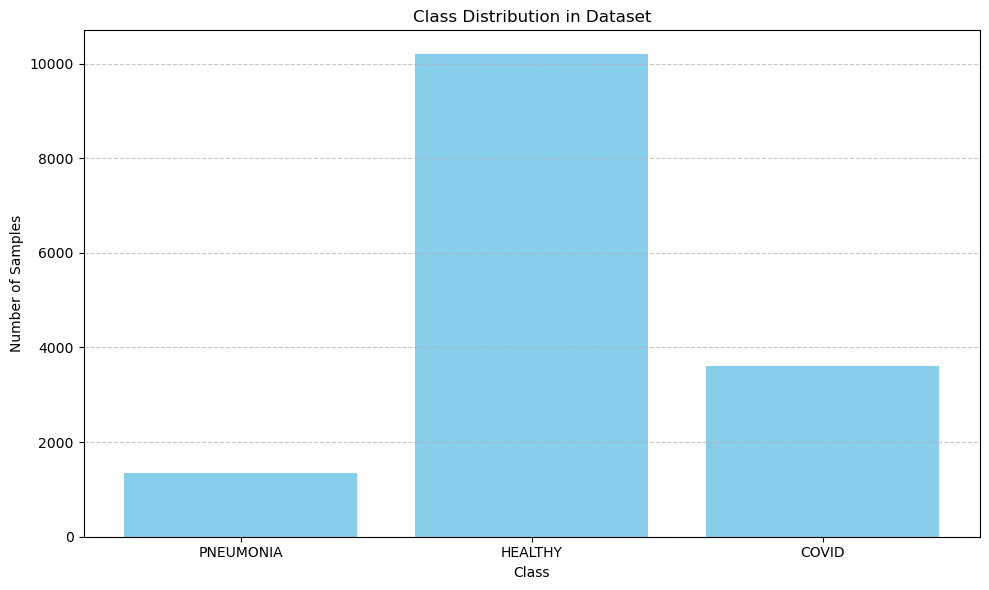

In [7]:
show_class_distribution_full(labels, class_names=classes)

As you can see, the distribution of the data here is very imbalanced to the healthy class. Since this tutorial is aimed at helping to distinguish between covid infected lungs to the other classes, balancing this dataset through data augmentation and would improve the final models precision and accuracy in classifying each class. 

First let's split the dataset into its train, validation and test splits

In [8]:
# Split into train and temp (validation + test)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    paths, labels, test_size=0.3, stratify=labels, random_state=42
)

# Split temp into validation and test
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

print(f"Train size: {len(train_paths)}, Validation size: {len(val_paths)}, Test size: {len(test_paths)}")


Train size: 10607, Validation size: 2273, Test size: 2273


In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])

I0000 00:00:1736410425.246062   16815 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736410425.246222   16815 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736410425.246299   16815 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736410425.819133   16815 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [10]:
def preprocess_image(img_path, label, target_size=(128, 128)):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)  # Ensure RGB format
    img.set_shape([None, None, 3])  # Explicitly set the shape to avoid shape errors
    img = tf.image.resize(img, target_size)  # Resize to the desired target size
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img

In [11]:
def create_balanced_dataset(
    train_paths, train_labels, batch_size=32, target_size=(128, 128), minority_classes=None
):
    """
    Create a balanced training dataset by augmenting minority class samples.

    Args:
        train_paths: List of training image paths.
        train_labels: Corresponding labels for the training images.
        batch_size: Batch size for the dataset.
        target_size: Target size for the images.
        minority_classes: List of minority class labels.

    Returns:
        A balanced TensorFlow dataset with augmented samples.
    """
    if minority_classes is None:
        raise ValueError("Please specify the minority classes.")

    # Count samples per class
    class_counts = {}
    for label in train_labels:
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

    # Determine the target number of samples (maximum class count)
    target_count = max(class_counts.values())
    print(f"Target count per class for balance: {target_count}")

    # Initialize containers for augmented images and labels
    augmented_images = []
    augmented_labels = []

    # Augment images for each class to balance the dataset
    for img_path, label in zip(train_paths, train_labels):
        # Preprocess the image
        img = preprocess_image(img_path, target_size)

        # Add the original image to the dataset
        augmented_images.append(img)
        augmented_labels.append(label)

        # Augment samples for minority classes
        while class_counts[label] < target_count:
            augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
            augmented_images.append(tf.squeeze(augmented_img, axis=0))  # Remove batch dimension
            augmented_labels.append(label)
            class_counts[label] += 1

    # Convert augmented data to a TensorFlow dataset
    augmented_dataset = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))
    
    # Shuffle, batch, and prefetch the dataset
    augmented_dataset = augmented_dataset.shuffle(buffer_size=1000)
    augmented_dataset = augmented_dataset.batch(batch_size)
    augmented_dataset = augmented_dataset.prefetch(tf.data.AUTOTUNE)

    return augmented_dataset


In [12]:
def create_tf_dataset_from_paths(paths, labels, batch_size=32, target_size=(128, 128)):
    """
    Create a TensorFlow dataset from image paths and labels without augmentation.

    Args:
        paths: List of image paths.
        labels: Corresponding labels.
        batch_size: Batch size for the dataset.
        target_size: Target size for the images.

    Returns:
        A TensorFlow dataset.
    """
    def preprocess(img_path, label):
        img = preprocess_image(img_path, target_size)
        return img, label

    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


In [13]:
def get_minority_classes(labels, threshold=None):
    """
    Identify minority classes based on their distribution.
    
    Args:
        labels: List of labels.
        threshold: Number of samples below which a class is considered minority.
                  If None, the threshold is set to the average class size.
    
    Returns:
        A set of minority class labels.
    """
    class_counts = Counter(labels)
    if threshold is None:
        threshold = sum(class_counts.values()) / len(class_counts)  # Use average class size
    return {cls for cls, count in class_counts.items() if count < threshold}


In [14]:
def inspect_dataset(dataset):
    """
    Inspects the dataset size and class distribution.

    Args:
        dataset: A TensorFlow dataset.

    Returns:
        A dictionary with class counts.
    """
    class_counts = {}
    for _, labels in dataset:
        for label in labels.numpy():
            class_counts[label] = class_counts.get(label, 0) + 1
    return class_counts


In [15]:
non_augmented_train_dataset = create_tf_dataset_from_paths(train_paths, train_labels, batch_size=32, target_size=(128, 128))

In [16]:
# Example usage
minority_classes = get_minority_classes(labels) 
train_dataset = create_balanced_dataset(
    train_paths, 
    train_labels, 
    batch_size=32, 
    target_size=(128, 128), 
    minority_classes=minority_classes
)

# Create validation and test datasets without augmentation
val_dataset = create_tf_dataset_from_paths(val_paths, val_labels, batch_size=32, target_size=(128, 128))
test_dataset = create_tf_dataset_from_paths(test_paths, test_labels, batch_size=32, target_size=(128, 128))

Target count per class for balance: 7134


In [17]:
inspect_dataset(non_augmented_train_dataset)

2025-01-09 08:17:38.485662: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{0: 942, 2: 2531, 1: 7134}

In [18]:
inspect_dataset(train_dataset)

2025-01-09 08:17:40.014844: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{0: 7134, 2: 7134, 1: 7134}

Using data augmentation, each class now has equal input to make it fair for the training process. Class balancing was not done on the validation and test set to reduce any overfitting possibilities

## Training Process


### Functions

In [19]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(300, activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')  # Adjust based on your dataset
    ])
    return model

base_model = create_model()
base_model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
base_model.summary()


/home/lunet/coaoo/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │    17,280,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,330,095 (66.11 MB)

 Trainable params: 17,330,095 (66.11 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
def accuracyOverLoss(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    #save_fig("keras_learning_curves_plot")
    plt.show()

In [21]:
def print_final_accuracy(history):
    final_train_accuracy = history.history['accuracy'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]

    print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
    print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")

In [27]:
def train_model_with_options(model, train_dataset, val_dataset, epochs=100, class_weights=None, callbacks=None, verbose=0):
    """
    Train a TensorFlow model with optional callbacks and class weights.

    Args:
        model: The compiled TensorFlow model.
        train_dataset: The training dataset.
        val_dataset: The validation dataset.
        epochs (int): The number of epochs to train the model. Default is 100.
        class_weights (dict or None): Class weights to handle class imbalance. Default is None.
        callbacks (list or None): List of callbacks to use during training. Default is None.
        verbose (int): Verbosity mode for training. 0 = silent, 1 = progress bar, 2 = one line per epoch.

    Returns:
        history: Training history object returned by model.fit().
    """
    # Train the model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        class_weight=class_weights,  # Apply class weights if provided
        callbacks=callbacks,  # Apply callbacks if provided
        verbose=verbose
    )
    return history

In [28]:

def build_complex_model(dropout_rate, l2_value, batchnormalised):
    if batchnormalised:
        model = k.models.Sequential([
            k.layers.Conv2D(32, (3, 3), kernel_regularizer=k.regularizers.l2(l2_value)),
            k.layers.BatchNormalization(),  # Add BatchNorm
            k.layers.Activation('relu'),
            k.layers.MaxPooling2D(pool_size=(2, 2)),
        
            k.layers.Conv2D(32, (3, 3), kernel_regularizer=k.regularizers.l2(l2_value)),
            k.layers.BatchNormalization(),  # Add BatchNorm
            k.layers.Activation('relu'),
            k.layers.MaxPooling2D(pool_size=(2, 2)),
        
            k.layers.Flatten(),
            k.layers.Dense(300, kernel_regularizer=k.regularizers.l2(l2_value)),
            k.layers.BatchNormalization(),  # Add BatchNorm
            k.layers.Activation('relu'),
            k.layers.Dropout(dropout_rate),  # Higher dropout for dense layers
        
            k.layers.Dense(100, kernel_regularizer=k.regularizers.l2(l2_value)),
            k.layers.BatchNormalization(),  # Add BatchNorm
            k.layers.Activation('relu'),
            k.layers.Dropout(dropout_rate),
        
            k.layers.Dense(3, activation='softmax')
        ])
        return model

    else:
        model = k.models.Sequential([
            k.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3),
                            kernel_regularizer=k.regularizers.l2(l2_value)),
            k.layers.MaxPooling2D(pool_size=(2, 2)),
        
            k.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=k.regularizers.l2(l2_value)),
            k.layers.MaxPooling2D(pool_size=(2, 2)),
        
            k.layers.Flatten(),
            k.layers.Dense(300, activation='relu', kernel_regularizer=k.regularizers.l2(l2_value)),
            k.layers.Dropout(dropout_rate), 
        
            k.layers.Dense(100, activation='relu', kernel_regularizer=k.regularizers.l2(l2_value)),
            k.layers.Dropout(dropout_rate),
        
            k.layers.Dense(3, activation='softmax')
        ])
        return model


### Base Model

2025-01-09 08:19:28.404456: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_155', 20 bytes spill stores, 20 bytes spill loads

2025-01-09 08:19:28.694918: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_395', 64 bytes spill stores, 64 bytes spill loads

2025-01-09 08:19:28.757099: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_395', 72 bytes spill stores, 72 bytes spill loads



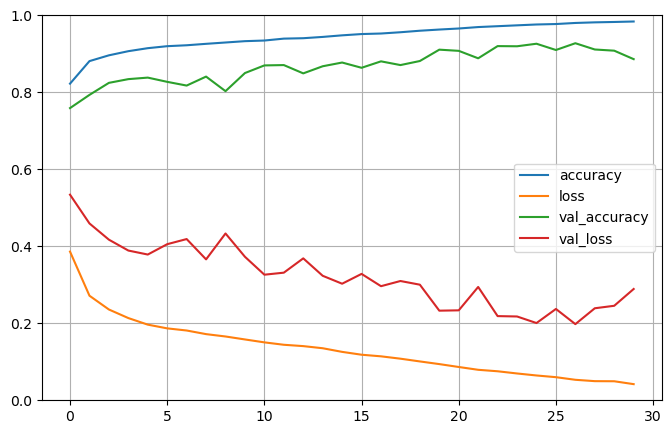

Final Training Accuracy: 0.9838
Final Validation Accuracy: 0.8861


In [29]:
base_model_history = train_model_with_options(base_model, train_dataset, val_dataset, 30)
accuracyOverLoss(base_model_history)
print_final_accuracy(base_model_history)

The graph shows erratic changes of the validations accuracy and loss. This indicated that there is a some overfitting happening with the model as it performs well with the training data but not with the validation dataset. By chaning the learning rate and optimiser function, the validation loss should reduce to improve the models generalisation capabiilities (ability correctly classify new data).

There are two ways to picking the learning rate. 
1. selecting one learning rate value for the whole training process
2. update the learning rate as the epochs increase based on the weight changes

but as the validation loss is not increasing but just being erractic, setting the learning rate for the whole training process will not yeild good results

so the best alternative is having a learning rate scheduler or using the delay method in the optimiser

### Learning rate Optimisation

/home/lunet/coaoo/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


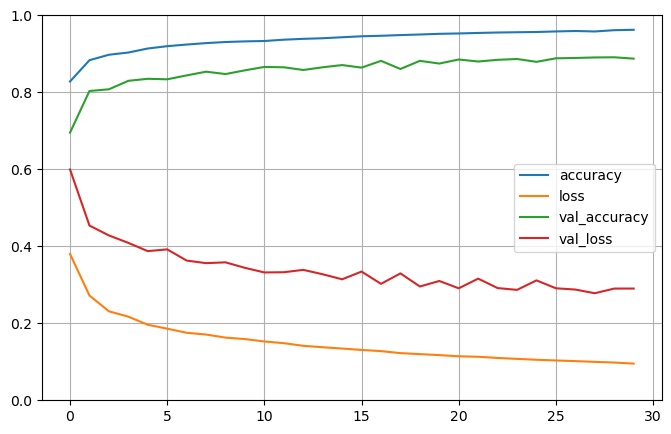

Final Training Accuracy: 0.9623
Final Validation Accuracy: 0.8874


In [30]:
lr_schedule = k.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1,
    decay_rate=1.0 / (1.0 + 0.0001))


exponential_decay_model = create_model()

optimizer = k.optimizers.SGD(learning_rate=lr_schedule)
exponential_decay_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

exponential_decay_history = exponential_decay_model.fit(train_dataset, epochs=30,
                    validation_data=val_dataset, verbose=0)

accuracyOverLoss(exponential_decay_history)
print_final_accuracy(exponential_decay_history)

/home/lunet/coaoo/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 21: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.


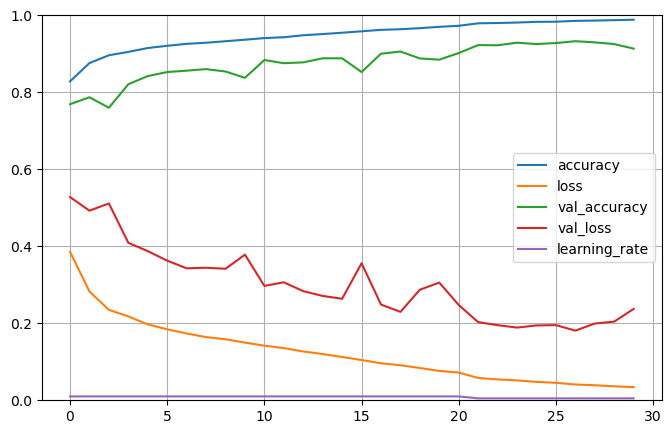

Final Training Accuracy: 0.9886
Final Validation Accuracy: 0.9133


In [31]:
reduced_lr_model = create_model()
optimiser = k.optimizers.SGD(learning_rate=0.01)
reduced_lr_model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
reduce_lr = k.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

reduced_lr_history =reduced_lr_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[reduce_lr],
    verbose=0
)


accuracyOverLoss(reduced_lr_history)
print_final_accuracy(reduced_lr_history)

I have chosen to utilizes ReduceLROnPlateau, over exponential decay due to its higher final accuracy. Despite some oscillations in the validation loss and accuracy, the superior accuracy indicates better overall performance. To address the instability, I will fine-tune model hyperparameters such as dropout rates, regularization strength, and learning rate adjustments to stabilize the results while maintaining high accuracy.

To address the instability, using adaptive methods like ReduceLROnPlateau allows the learning rate to be updated based on the drastic change in weights to make for a stable model. Using other optimiser like Adam can have a similar effect

### Optimers, Dropout Rate And Regalarization Optimization
utilising the Keras Tuner, as described in [Introduction to the Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner) (TensorFlow Core).


In [32]:
# Using Keras Tuner for hyperparameter optimization
# Source: Introduction to the Keras Tuner. TensorFlow Core. Available at: https://www.tensorflow.org/tutorials/keras/keras_tuner (Accessed: 07 January 2025)
def build_model(hp):
    # Hyperparameters to tune
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    l2_value = hp.Choice('l2_value', values=[0.0001, 0.001, 0.01])
    learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])
    optimizer = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
    
    # Model definition
    model = k.models.Sequential([
        k.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3),
                        kernel_regularizer=k.regularizers.l2(l2_value)),
        k.layers.MaxPooling2D(pool_size=(2, 2)),

        k.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=k.regularizers.l2(l2_value)),
        k.layers.MaxPooling2D(pool_size=(2, 2)),

        k.layers.Flatten(),
        k.layers.Dense(300, activation='relu', kernel_regularizer=k.regularizers.l2(l2_value)),
        k.layers.Dropout(dropout_rate),  # Higher dropout for dense layers

        k.layers.Dense(100, activation='relu', kernel_regularizer=k.regularizers.l2(l2_value)),
        k.layers.Dropout(dropout_rate),

        k.layers.Dense(3, activation='softmax')
    ])
    
    # Select optimizer
    if optimizer == 'adam':
        opt = k.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = k.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = k.optimizers.RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [34]:
# Keras Tuner setup
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
)

# Run search
tuner.search(train_dataset, validation_data=val_dataset, epochs=30)

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Best L2 Value: {best_hps.get('l2_value')}")
print(f"Best Learning Rate: {best_hps.get('learning_rate')}")
print(f"Best Optimizer: {best_hps.get('optimizer')}")

k.backend.clear_session()


Trial 29 Complete [00h 01m 37s]
val_loss: 0.5019564628601074

Best val_loss So Far: 0.22025802731513977
Total elapsed time: 00h 18m 23s
Best Dropout Rate: 0.30000000000000004
Best L2 Value: 0.0001
Best Learning Rate: 0.001
Best Optimizer: rmsprop


### Batch Normalised Vs Non Batch Normalised


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 21: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 24: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 27: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 30: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.


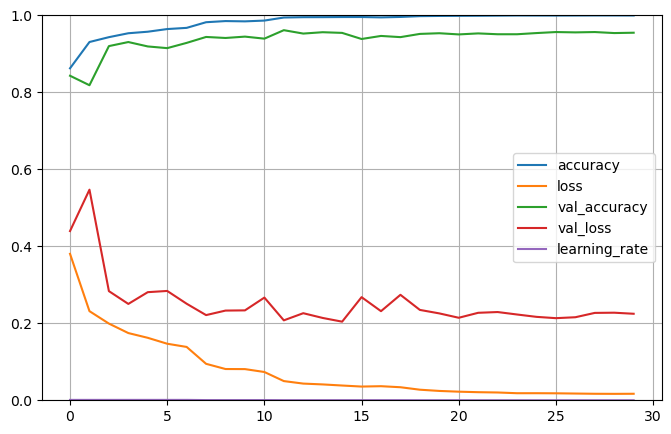

Final Training Accuracy: 0.9995
Final Validation Accuracy: 0.9547


In [35]:
k.backend.clear_session()
regularisation_model = build_complex_model(0.3, 0.0001, False)
optimiser = k.optimizers.RMSprop(learning_rate=0.001)
regularisation_model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

regularised_history =regularisation_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[reduce_lr],
    verbose=0
)

accuracyOverLoss(regularised_history)
print_final_accuracy(regularised_history)


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 17: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 23: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 27: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.


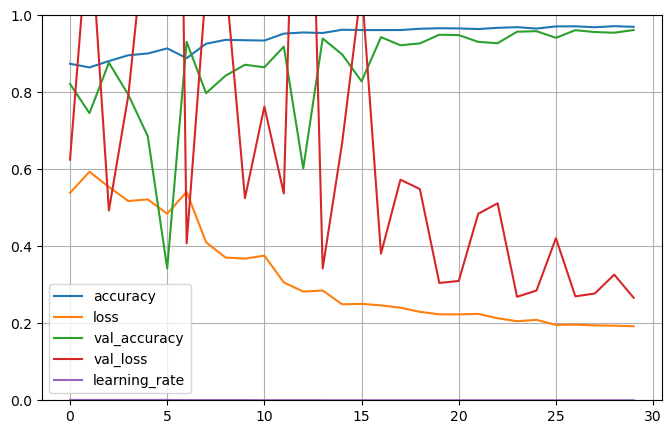

Final Training Accuracy: 0.9700
Final Validation Accuracy: 0.9617


In [36]:
k.backend.clear_session()
batchnormalised_model = build_complex_model(0.3, 0.0001, True)
optimiser = k.optimizers.RMSprop(learning_rate=0.001)
batchnormalised_model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

batchnormalised_history = batchnormalised_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[reduce_lr],
    verbose=0
)

accuracyOverLoss(batchnormalised_history)
print_final_accuracy(batchnormalised_history)

#### Accuracy and Validation Accuracy:
- Batch-Normalized Model: Although it achieves high final training and validation accuracies, the validation accuracy fluctuates erratically throughout the training process. This suggests instability in how the model generalizes to unseen data.
  
- Non-Batch-Normalized Model: Achieves a final training accuracy of 0.9991 and a validation accuracy of 0.9454. Despite a slight overfitting tendency (as indicated by the gap between training and validation accuracies), the performance is more stable and consistent compared to the batch-normalized

  
#### Validation Loss
- Batch-Normalized Model: The validation loss fluctuates significantly, with sharp spikes and drops. This erratic behavior indicates that the batch normalization layer is potentially interfering with the optimization process, making it harder for the model to converge effectively on the validation set.

- Non-Batch-Normalized Model: Shows smoother and more predictable trends in validation loss, even though it does not perform as well in terms of minimizing the loss.

#### Conclusion
The batch-normalized model demonstrates erratic behavior in both validation accuracy and loss, indicating instability during training. While batch normalization is supppose improves generalization and stabilization, in this case, it seems to disrupt the training process, which is likely because of an incompatibilty with the hyperparameters. 

The non-batch-normalized model, although slightly overfitting, performs more consistently and achieves stable trends. Further hyperparameter tuning or modifications to the batch normalization implementation may be necessary to harness its full potential.

## Evaluation

### Final Model Evaluation

/home/lunet/coaoo/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


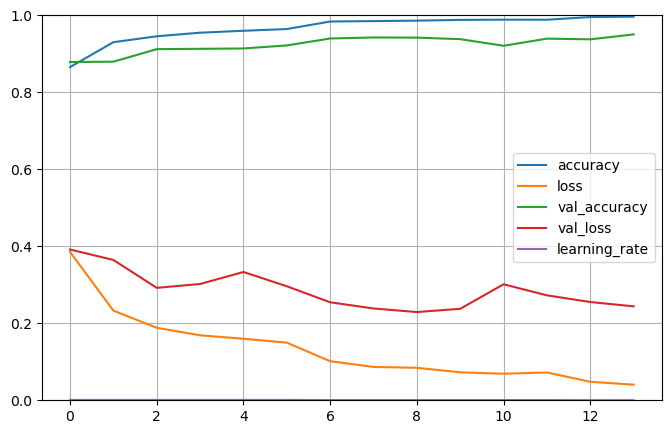

Final Training Accuracy: 0.9964
Final Validation Accuracy: 0.9503


In [37]:
k.backend.clear_session()
final_model = build_complex_model(0.3, 0.0001, False)
optimiser = k.optimizers.RMSprop(learning_rate=0.001)
final_model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


early_stopping = k.callbacks.EarlyStopping(
    monitor='val_loss',      
    patience=5,              
    min_delta=1e-4,           
    restore_best_weights=True 
)

final_model_history =final_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)

accuracyOverLoss(final_model_history)
print_final_accuracy(final_model_history)

In [38]:
final_model.evaluate(test_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9486 - loss: 0.2204


[0.21974386274814606, 0.9485262036323547]

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


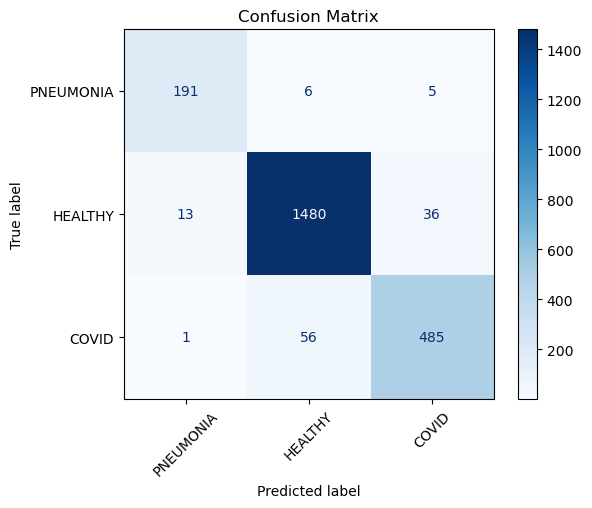

Class PNEUMONIA Accuracy: 94.55%
Class HEALTHY Accuracy: 96.80%
Class COVID Accuracy: 89.48%

Classification Report:

              precision    recall  f1-score   support

   PNEUMONIA       0.93      0.95      0.94       202
     HEALTHY       0.96      0.97      0.96      1529
       COVID       0.92      0.89      0.91       542

    accuracy                           0.95      2273
   macro avg       0.94      0.94      0.94      2273
weighted avg       0.95      0.95      0.95      2273



In [39]:
def evaluate_model_performance(model, test_dataset, class_names):
    """
    Evaluates the model's performance on the test dataset and displays:
    - Confusion matrix
    - Per-class accuracy
    - Classification report

    Args:
        model: Trained TensorFlow/Keras model.
        test_dataset: Test dataset (should be a TensorFlow Dataset object).
        class_names: List of class names.

    Returns:
        None
    """
    y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)
    y_pred = np.argmax(model.predict(test_dataset), axis=-1)

    conf_matrix = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

    # Calculate per-class accuracy
    class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
    for idx, accuracy in enumerate(class_accuracy):
        print(f"Class {class_names[idx]} Accuracy: {accuracy * 100:.2f}%")

    # Show overall classification report
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))


evaluate_model_performance(final_model, test_dataset, classes) 


As you can see, the model produces high accuracies and precision for each class predicted values. Since the model is used for aiding the classification of mainly the covid infected lungs, balancing the data so more covid infected images were present could have increased its performance. 

Another thing that aided in the high performance of this model was the data augmentation at the start of this tutorial. this allowed the data which was originally skewed towards healthy patients to be balanced equally between all classes through the introduction of more data.

as a comparision, train and evaluating the famous architecture, RESNET50 to see how it compares to my model will prove to be interesting

### Final Model And Resnet50 Model Comparision

In [40]:
resnet_model = k.applications.ResNet50(
    include_top=False,
    weights=None,  # Train from scratch
    input_shape=(128, 128, 3)
)

# Add classification layers to ResNet50
resnet_model = k.models.Sequential([
    resnet_model,
    k.layers.GlobalAveragePooling2D(),
    k.layers.Dense(300, activation='relu', kernel_regularizer=k.regularizers.l2(0.001)),
    k.layers.Dropout(0.3),
    k.layers.Dense(100, activation='relu', kernel_regularizer=k.regularizers.l2(0.001)),
    k.layers.Dropout(0.3),
    k.layers.Dense(3, activation='softmax')
])

# Compile the ResNet50 model
resnet_model.compile(
    optimizer=k.optimizers.RMSprop(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the ResNet50 model
resnet_history = resnet_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[reduce_lr]
)

print_final_accuracy(resnet_history)

Epoch 1/30


2025-01-09 08:50:06.776806: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14810', 144 bytes spill stores, 144 bytes spill loads



667/669 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9445 - loss: 0.4216

2025-01-09 08:50:40.163737: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14810', 184 bytes spill stores, 184 bytes spill loads



669/669 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.9441 - loss: 0.4217 - val_accuracy: 0.6951 - val_loss: 0.8180 - learning_rate: 0.0010
Epoch 2/30
669/669 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.9290 - loss: 0.2085 - val_accuracy: 0.6304 - val_loss: 1.2979 - learning_rate: 0.0010
Epoch 3/30
669/669 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.9402 - loss: 0.2034 - val_accuracy: 0.5293 - val_loss: 1.7733 - learning_rate: 0.0010
Epoch 4/30
669/669 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.9401 - loss: 0.2046 - val_accuracy: 0.7448 - val_loss: 0.6413 - learning_rate: 0.0010
Epoch 5/30
669/669 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.9367 - loss: 0.1976 - val_accuracy: 0.2842 - val_loss: 1.1126 - learning_rate: 0.0010
Epoch 6/30
669/669 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.9183 - loss: 0.2551 - val_accuracy: 0.2750 - val_loss: 1.3339 - learning_rate: 0.0010
Epoch 7/30
669/669 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.9261 - loss: 0.2171

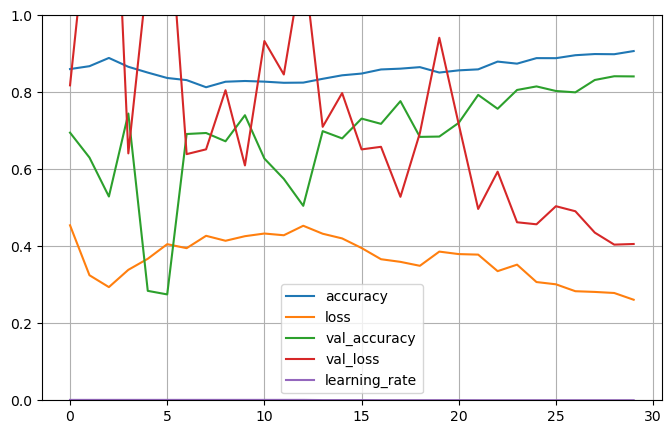

In [41]:
accuracyOverLoss(resnet_history)

72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step


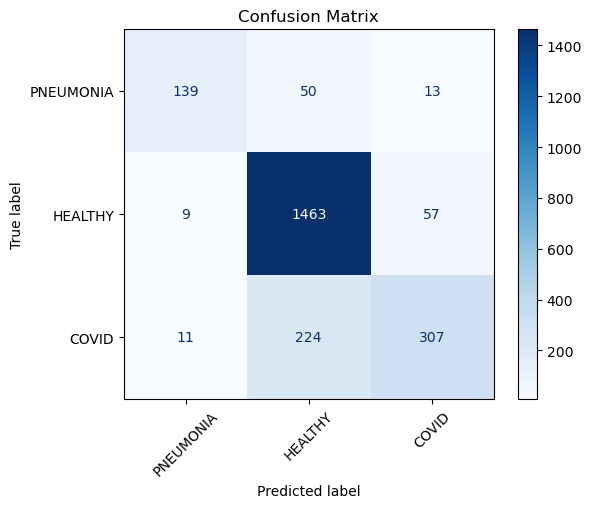

Class PNEUMONIA Accuracy: 68.81%
Class HEALTHY Accuracy: 95.68%
Class COVID Accuracy: 56.64%

Classification Report:

              precision    recall  f1-score   support

   PNEUMONIA       0.87      0.69      0.77       202
     HEALTHY       0.84      0.96      0.90      1529
       COVID       0.81      0.57      0.67       542

    accuracy                           0.84      2273
   macro avg       0.84      0.74      0.78      2273
weighted avg       0.84      0.84      0.83      2273



In [42]:
evaluate_model_performance(resnet_model, test_dataset, classes) 

## References
- Introduction to the Keras Tuner. TensorFlow Core (no date). TensorFlow. Available at: [https://www.tensorflow.org/tutorials/keras/keras_tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner) (Accessed: 07 January 2025).
- GeeksforGeeks (2024) How to handle class imbalance in tensorflow?, GeeksforGeeks. Available at: [https://www.geeksforgeeks.org/how-to-handle-class-imbalance-in-tensorflow/](https://www.geeksforgeeks.org/how-to-handle-class-imbalance-in-tensorflow/) (Accessed: 08 January 2025).
- ChenDataBytes (2023) A simple convolutional neural network (CNN) classifier based on real images, Medium. Available at: https://medium.com/@chenycy/a-simple-convolutional-neural-network-cnn-classifier-based-on-real-images-084110d52c18 (Accessed: 09 January 2025).
- Awan, A.A. (2024) A complete guide to data augmentation, DataCamp. Available at: https://www.datacamp.com/tutorial/complete-guide-data-augmentation (Accessed: 09 January 2025). 